In [ ]:
!pip install accelerate -U

In [ ]:
!pip install -q datasets transformers

In [ ]:
from zipfile import ZipFile
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
import torchvision.transforms as T
from torch.utils.data import DataLoader,TensorDataset,Subset,Dataset,random_split
import copy
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from IPython import display
import pandas as pd
import numpy as np
import os
from torchvision.io import read_image
from torchvision.utils import make_grid
from skimage import io
display.set_matplotlib_formats('svg')

In [4]:
!mkdir ~/.kaggle

In [5]:
! cp /content/kaggle.json ~/.kaggle/

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets download -d ashfakyeafi/cat-dog-images-for-classification

 97% 529M/545M [00:04<00:00, 99.7MB/s]
100% 545M/545M [00:04<00:00, 114MB/s] 


In [8]:
# Put on the same directory

# specifying the name of the zip file
file = "cat-dog-images-for-classification.zip"

# open the zip file in read mode
with ZipFile(file, 'r') as zip:
    # list all the contents of the zip file
    zip.printdir()

    # extract all files
    print('extraction...')
    zip.extractall()
    print('Done!')

Streaming output truncated to the last 5000 lines.
cat_dog/dog.550.jpg                            2023-12-12 18:56:26         4826
cat_dog/dog.5500.jpg                           2023-12-12 18:56:26        44699
cat_dog/dog.5501.jpg                           2023-12-12 18:56:26        30379
cat_dog/dog.5502.jpg                           2023-12-12 18:56:26        25140
cat_dog/dog.5503.jpg                           2023-12-12 18:56:26        21938
cat_dog/dog.5504.jpg                           2023-12-12 18:56:26         7717
cat_dog/dog.5505.jpg                           2023-12-12 18:56:26        26625
cat_dog/dog.5506.jpg                           2023-12-12 18:56:26         8554
cat_dog/dog.5507.jpg                           2023-12-12 18:56:26        19899
cat_dog/dog.5508.jpg                           2023-12-12 18:56:26         9154
cat_dog/dog.5509.jpg                           2023-12-12 18:56:26        25600
cat_dog/dog.551.jpg                            2023-12-12 18:56:26   

In [9]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        self.img_labels = annotations_file
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        return image,label

In [10]:
img_dir='/content/cat_dog'

In [11]:
annotations_file= pd.read_csv('/content/cat_dog.csv')
train_label, test_label=train_test_split(annotations_file,test_size=0.3,random_state=42)
len(train_label),len(test_label)


(17500, 7500)

In [12]:
label2id={'cat':0,'dog':1}
id2label={0:'cat',1:'dog'}

In [13]:
model_checkpoint = "google/vit-base-patch16-224-in21k"

In [14]:
from transformers import AutoImageProcessor

image_processor  = AutoImageProcessor.from_pretrained(model_checkpoint)
image_processor

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [15]:
normalize = T.Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
if "height" in image_processor.size:
    size = (image_processor.size["height"], image_processor.size["width"])
    crop_size = size
    max_size = None
elif "shortest_edge" in image_processor.size:
    size = image_processor.size["shortest_edge"]
    crop_size = (size, size)
    max_size = image_processor.size.get("longest_edge")


In [16]:
TTs = T.Compose([
                 T.ToPILImage(),
                 T.RandomResizedCrop(crop_size),
                 T.RandomRotation(degrees=45),
                 T.RandomHorizontalFlip(p=0.3),
                 T.RandomVerticalFlip(p=0.05),
                 T.ToTensor(),
                 normalize
                  ])


VTs= T.Compose([
                 T.ToPILImage(),
                 T.Resize(size),
                 T.CenterCrop(crop_size),
                 T.ToTensor(),
                 normalize
                  ])

In [17]:
train_dataset =CustomImageDataset(
    annotations_file=train_label,
    img_dir=img_dir,
    transform=TTs
)

test_dataset=CustomImageDataset(
    annotations_file=test_label,
    img_dir=img_dir,
    transform=VTs
)


In [18]:
len(train_dataset),len(test_dataset)

(17500, 7500)

In [19]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [20]:
x,y=next(iter(train_dataloader))
x.data.shape

torch.Size([32, 3, 224, 224])

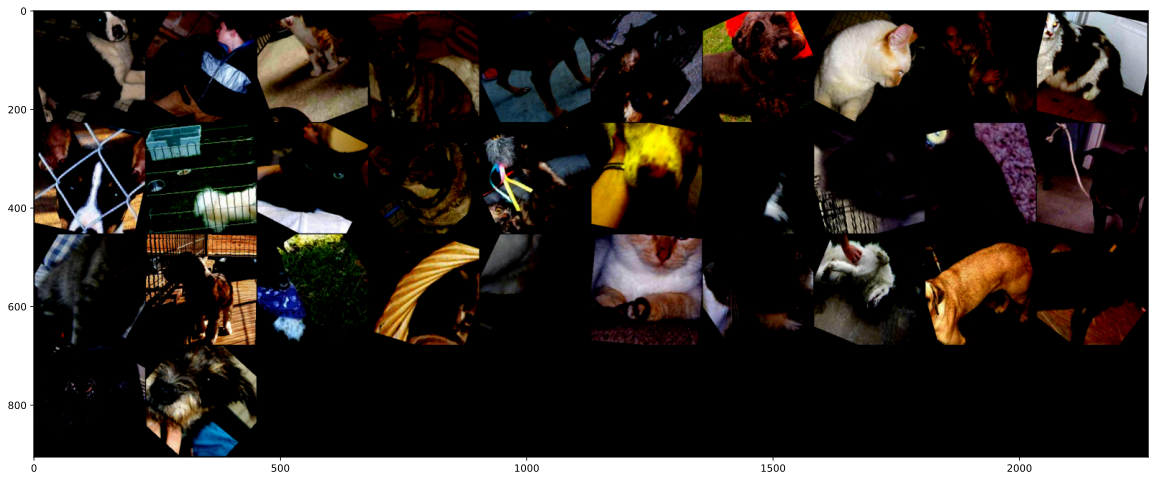

In [21]:
fig, ax = plt.subplots(figsize=(20,20))
ax.imshow(make_grid(x[:100], 10).permute(1, 2, 0))

# **Build CNN model**

In [22]:
class block(nn.Module):
    def __init__(self,in_channel,out_channel,**kwargs):
        super(block,self).__init__()

        self.network=nn.Sequential(
            nn.Conv2d(in_channel,out_channel,**kwargs),
            nn.BatchNorm2d(out_channel),
            nn.ReLU()

        )
    def forward(self,x):
        return self.network(x)

In [23]:
class cat_dog_net(nn.Module):
    def __init__(self, ):
      super().__init__()
# 1st convolution layer
      self.conv1  = block(3,32,kernel_size=1,padding=1)
      #(224+2*1-1)/1 + 1 = 226 = 226 (/2 b/c maxpool)

      # 2nd convolution layer
      self.conv2  = block(32,64,kernel_size=5,padding=1)

# output size: (226+2*1-5)/1 + 1 = 224 =224 (/2 b/c maxpool)
      # 3rd convolution layer
      self.conv3  = block(64,128,kernel_size=3,padding=1)
# output size: (224+2*1-3)/1 + 1 =224/2 =112 (/2 b/c maxpool)
      # 4th convolution layer
      self.conv4  = block(128,256,kernel_size=3,padding=1)
# output size: (112+2*1-3)/1 + 1 = 112/2 = 65 (/2 b/c maxpool)
      # 5th convolution layer
      self.conv5  =block(256,128,kernel_size=3,padding=1)
# output size: (56+2*1-3)/1 + 1 = 56/2 = 28 (/2 b/c maxpool)


      # 6th convolution layer
      self.conv6  =block(128,64,kernel_size=3,padding=1)
# output size: (28+2*1-3)/1 + 1 =28/2 = 14 (/2 b/c maxpool)


      # 7th convolution layer
      self.conv7  =block(64,32,kernel_size=3,padding=1)
# output size: (14+2*1-3)/1 + 1 =14  (/2 b/c maxpool)

      # 8th convolution layer
      self.conv8  =block(32,64,kernel_size=3,padding=1)
# output size: (14+2*1-3)/1 + 1 =14  (/2 b/c maxpool)


      # 9th convolution layer
      self.conv9  =block(64,128,kernel_size=3,padding=1)
# output size: (14+2*1-3)/1 + 1 =14/2 =7  (/2 b/c maxpool)


      ### -------------- linear decision layers -------------- ###
      self.fc1 = nn.Linear(7*7*128,128)
      self.fc2 = nn.Linear(128,64)
      self.fc3 = nn.Linear(64,50)
      self.fc4 = nn.Linear(50,2)


    def forward(self,x):

      # 1st block: convolution -> maxpool -> batchnorm -> relu
      x =self.conv1(x)

      # 2nd block: convolution -> maxpool -> batchnorm -> relu
      x =self.conv2(x)

      # 3rd block: convolution -> maxpool -> batchnorm -> relu
      x =F.max_pool2d(self.conv3(x),2)

      # 4th block: convolution -> maxpool -> batchnorm -> relu
      x =F.max_pool2d(self.conv4(x),2)

      # 5th block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv5(x),2)

      # 6th block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv6(x),2)


      # 7th block: convolution -> maxpool -> batchnorm -> relu
      x = self.conv7(x)

      # 8th block: convolution -> maxpool -> batchnorm -> relu
      x = self.conv8(x)


      # 9th block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv9(x),2)



      x = F.dropout(x,p=.25,training=self.training)

      # reshape for linear layer
      nUnits = x.shape.numel()/x.shape[0]
      x = x.view(-1,int(nUnits))

      # linear layers
      x = F.leaky_relu(self.fc1(x))
      x = F.leaky_relu(self.fc2(x))
      x = F.leaky_relu(self.fc3(x))
      x = F.dropout(x,p=.25,training=self.training)

      x = self.fc4(x)

      return x

In [24]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [25]:
# a function that trains the model

def train(net,numepochs,lossfun,optimizer,train_loader,dev_loader):

  # send the model to the GPU
  net.to(device)

  # initialize losses
  trainLoss = torch.zeros(numepochs)
  devLoss   = torch.zeros(numepochs)
  trainAcc  = torch.zeros(numepochs)
  devAcc    = torch.zeros(numepochs)


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    net.train() # switch to train mode
    batchLoss = []
    batchAcc  = []
    for X,y in train_loader:

      # push data to GPU
      X = X.to(device)
      y = y.to(device)

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss and accuracy from this batch
      batchLoss.append(loss.item())
      batchAcc.append( torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
    # end of batch loop...

    # and get average losses and accuracies across the batches
    trainLoss[epochi] = np.mean(batchLoss)
    trainAcc[epochi]  = 100*np.mean(batchAcc)


    #### test performance
    net.eval() # switch to test mode
    batchAcc  = []
    batchLoss = []
    for X,y in dev_loader:

      # push data to GPU
      X = X.to(device)
      y = y.to(device)

      # forward pass and loss
      with torch.no_grad():
        yHat = net(X)
        loss = lossfun(yHat,y)

      # loss and accuracy from this batch
      batchLoss.append(loss.item())
      batchAcc.append( torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
    # end of batch loop...

    # and get average losses and accuracies across the batches
    devLoss[epochi] = np.mean(batchLoss)
    devAcc[epochi]  = 100*np.mean(batchAcc)
    print(f'Finished epoch {epochi+1}/{numepochs}. devAcc = {devAcc[epochi]:.2f}%')


  # end epochs

  # function output
  return trainLoss,devLoss,trainAcc,devAcc,net


In [26]:
# function to plot the results
def plot_results(trainLoss,devLoss,trainAcc,devAcc):
  fig,ax = plt.subplots(1,2,figsize=(16,5))

  ax[0].plot(trainLoss,'s-',label='Train')
  ax[0].plot(devLoss,'s-',label='Test')
  ax[0].set_xlabel('Epochs')
  ax[0].set_ylabel('Loss')
  ax[0].set_title('Model loss')

  ax[1].plot(trainAcc,'s-',label='Train')
  ax[1].plot(devAcc,'o-',label='Test')
  ax[1].set_xlabel('Epochs')
  ax[1].set_ylabel('Accuracy (%)')
  ax[1].set_title(f'Final model test accuracy: {devAcc[-1]:.2f}%')
  ax[1].legend()

  plt.show()

In [ ]:
  # number of epochs
  numepochs = 20
  # create the model instance
  net = cat_dog_net()
  # loss function
  lossfun = nn.CrossEntropyLoss()
  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001,weight_decay=1e-5)

In [ ]:
trainLoss,devLoss,trainAcc,devAcc,net =train(net,numepochs,lossfun,optimizer,train_dataloader,test_dataloader)

Finished epoch 1/20. devAcc = 58.27%
Finished epoch 2/20. devAcc = 67.49%
Finished epoch 3/20. devAcc = 67.39%
Finished epoch 4/20. devAcc = 67.94%
Finished epoch 5/20. devAcc = 68.10%
Finished epoch 6/20. devAcc = 68.53%
Finished epoch 7/20. devAcc = 71.60%
Finished epoch 8/20. devAcc = 70.93%
Finished epoch 9/20. devAcc = 72.34%
Finished epoch 10/20. devAcc = 74.04%
Finished epoch 11/20. devAcc = 74.87%
Finished epoch 12/20. devAcc = 73.52%
Finished epoch 13/20. devAcc = 78.64%
Finished epoch 14/20. devAcc = 77.12%
Finished epoch 15/20. devAcc = 78.74%
Finished epoch 16/20. devAcc = 83.29%
Finished epoch 17/20. devAcc = 82.46%
Finished epoch 18/20. devAcc = 84.75%
Finished epoch 19/20. devAcc = 79.45%
Finished epoch 20/20. devAcc = 84.17%


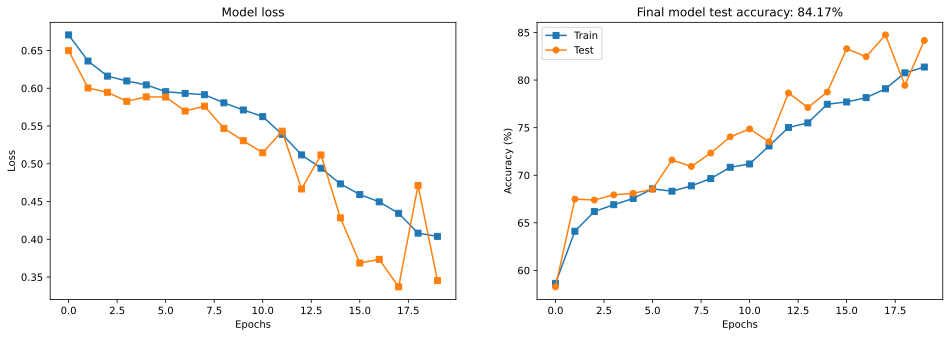

In [ ]:
plot_results(trainLoss,devLoss,trainAcc,devAcc)

# pre-train mobilenet model without freezing any layers

In [ ]:
mobilenet_model = models.mobilenet_v2(pretrained=True)
mobilenet_model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 62.4MB/s]


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [ ]:
mobilenet_model.classifier[1] = nn.Linear(mobilenet_model.last_channel, 2)

In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optim =torch.optim.Adam(mobilenet_model.parameters(), lr=.001)
epochs = 30
mobilenet_model_trainLoss,mobilenet_model_devLoss,mobilenet_model_trainAcc,mobilenet_model_devAcc,mobilenet_model =train(mobilenet_model,epochs,criterion,optim,train_dataloader,test_dataloader)


Finished epoch 1/30. devAcc = 93.74%
Finished epoch 2/30. devAcc = 93.57%
Finished epoch 3/30. devAcc = 94.47%
Finished epoch 4/30. devAcc = 93.89%
Finished epoch 5/30. devAcc = 94.59%
Finished epoch 6/30. devAcc = 94.61%
Finished epoch 7/30. devAcc = 93.80%
Finished epoch 8/30. devAcc = 94.99%
Finished epoch 9/30. devAcc = 94.03%
Finished epoch 10/30. devAcc = 94.15%
Finished epoch 11/30. devAcc = 94.52%
Finished epoch 12/30. devAcc = 95.47%
Finished epoch 13/30. devAcc = 94.70%
Finished epoch 14/30. devAcc = 94.27%
Finished epoch 15/30. devAcc = 95.58%
Finished epoch 16/30. devAcc = 95.70%
Finished epoch 17/30. devAcc = 94.02%
Finished epoch 18/30. devAcc = 95.97%
Finished epoch 19/30. devAcc = 95.98%
Finished epoch 20/30. devAcc = 94.95%
Finished epoch 21/30. devAcc = 95.15%
Finished epoch 22/30. devAcc = 95.74%
Finished epoch 23/30. devAcc = 95.92%
Finished epoch 24/30. devAcc = 95.99%
Finished epoch 25/30. devAcc = 96.34%
Finished epoch 27/30. devAcc = 96.64%
Finished epoch 28/30.

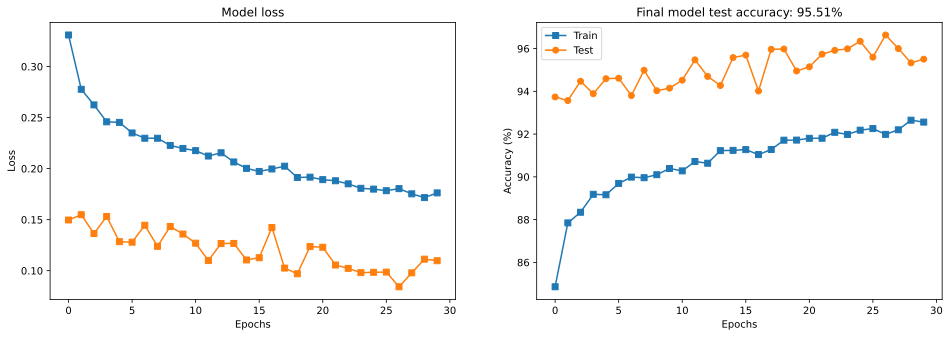

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(mobilenet_model_trainLoss,'s-',label='Train')
ax[0].plot(mobilenet_model_devLoss,'s-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')

ax[1].plot(mobilenet_model_trainAcc,'s-',label='Train')
ax[1].plot(mobilenet_model_devAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {mobilenet_model_devAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

# pre-train mobilenet model with freezing any layers

In [ ]:
mobilenet_model_wfa = models.mobilenet_v2(pretrained=True)
mobilenet_model_wfa

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 84.7MB/s]


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [ ]:
# Freeze all the layers of the pre-trained model
for param in mobilenet_model_wfa.parameters():
    param.requires_grad = False

In [ ]:
mobilenet_model_wfa.classifier[1] = nn.Linear(mobilenet_model_wfa.last_channel, 2)

In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optim =torch.optim.Adam(mobilenet_model_wfa.parameters(), lr=.001,weight_decay=1e-5)
epochs = 30
mobilenet_model_wfa_trainLoss,mobilenet_model_wfa_devLoss,mobilenet_model_wfa_trainAcc,mobilenet_model_wfa_devAcc,mobilenet_model_wfa =train(mobilenet_model_wfa,epochs,criterion,optim,train_dataloader,test_dataloader)


Finished epoch 1/30. devAcc = 95.52%
Finished epoch 2/30. devAcc = 95.06%
Finished epoch 3/30. devAcc = 96.34%
Finished epoch 4/30. devAcc = 96.17%
Finished epoch 5/30. devAcc = 96.12%
Finished epoch 6/30. devAcc = 96.33%
Finished epoch 7/30. devAcc = 96.00%
Finished epoch 8/30. devAcc = 96.24%
Finished epoch 9/30. devAcc = 96.39%
Finished epoch 10/30. devAcc = 95.88%
Finished epoch 11/30. devAcc = 95.86%
Finished epoch 12/30. devAcc = 96.40%
Finished epoch 13/30. devAcc = 96.40%
Finished epoch 14/30. devAcc = 96.65%
Finished epoch 15/30. devAcc = 96.32%
Finished epoch 16/30. devAcc = 96.32%
Finished epoch 17/30. devAcc = 96.41%
Finished epoch 18/30. devAcc = 96.35%
Finished epoch 19/30. devAcc = 96.48%
Finished epoch 20/30. devAcc = 96.44%
Finished epoch 21/30. devAcc = 96.02%
Finished epoch 22/30. devAcc = 96.37%
Finished epoch 23/30. devAcc = 96.30%
Finished epoch 24/30. devAcc = 95.90%
Finished epoch 25/30. devAcc = 95.60%
Finished epoch 26/30. devAcc = 96.37%
Finished epoch 27/30.

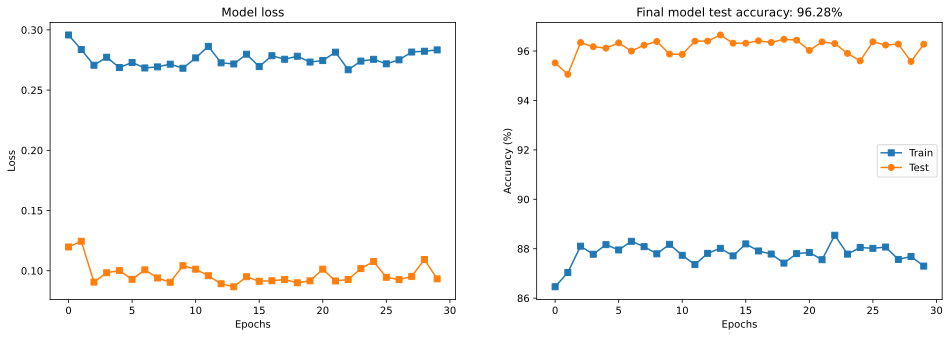

In [ ]:
plot_results(mobilenet_model_wfa_trainLoss,mobilenet_model_wfa_devLoss,mobilenet_model_wfa_trainAcc,mobilenet_model_wfa_devAcc)

# pre-train mobilenet with freezing conv layers only

In [ ]:
mobilenet_model_wfp = models.mobilenet_v2(pretrained=True)
mobilenet_model_wfp

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 95.4MB/s]


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [ ]:
# Freeze only the convolutional layers of the pre-trained model
for param in mobilenet_model_wfp.parameters():
    if isinstance(param, nn.Conv2d):
        param.requires_grad = False

In [ ]:
mobilenet_model_wfp.classifier[1] = nn.Linear(mobilenet_model_wfp.last_channel, 2)

In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optim =torch.optim.Adam(mobilenet_model_wfp.parameters(), lr=.001,weight_decay=0.0001)
epochs = 30
mobilenet_model_wfp_trainLoss,mobilenet_model_wfp_devLoss,mobilenet_model_wfp_trainAcc,mobilenet_model_wfp_devAcc,mobilenet_model_wfp =train(mobilenet_model_wfp,epochs,criterion,optim,train_dataloader,test_dataloader)


Finished epoch 1/30. devAcc = 93.61%
Finished epoch 2/30. devAcc = 92.74%
Finished epoch 3/30. devAcc = 94.73%
Finished epoch 4/30. devAcc = 94.56%
Finished epoch 5/30. devAcc = 92.94%
Finished epoch 6/30. devAcc = 93.26%
Finished epoch 7/30. devAcc = 93.65%
Finished epoch 8/30. devAcc = 94.26%
Finished epoch 9/30. devAcc = 94.07%
Finished epoch 10/30. devAcc = 94.66%
Finished epoch 11/30. devAcc = 94.45%
Finished epoch 12/30. devAcc = 94.33%
Finished epoch 13/30. devAcc = 95.09%
Finished epoch 14/30. devAcc = 95.00%
Finished epoch 15/30. devAcc = 94.62%
Finished epoch 16/30. devAcc = 93.48%
Finished epoch 17/30. devAcc = 95.41%
Finished epoch 18/30. devAcc = 92.06%
Finished epoch 19/30. devAcc = 95.39%
Finished epoch 20/30. devAcc = 94.27%
Finished epoch 21/30. devAcc = 94.81%
Finished epoch 22/30. devAcc = 93.51%
Finished epoch 23/30. devAcc = 93.75%
Finished epoch 24/30. devAcc = 94.25%
Finished epoch 25/30. devAcc = 93.47%
Finished epoch 26/30. devAcc = 94.77%
Finished epoch 27/30.

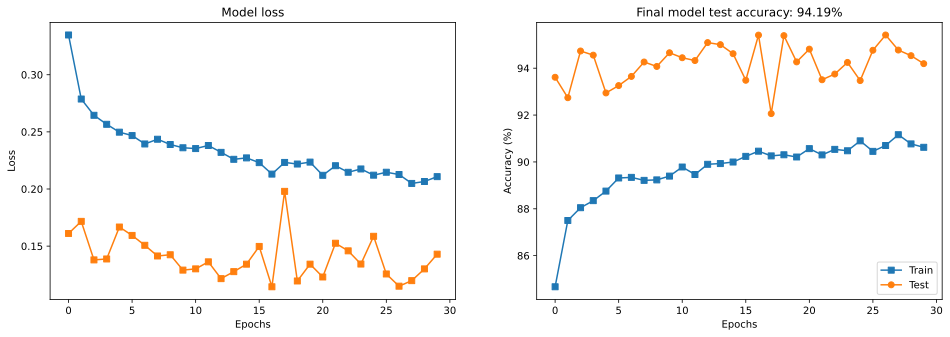

In [ ]:
plot_results(mobilenet_model_wfp_trainLoss,mobilenet_model_wfp_devLoss,mobilenet_model_wfp_trainAcc,mobilenet_model_wfp_devAcc)

# pre-train mobilenet model with freezing the first two layers

In [27]:
mobilenet_model_wf1 = models.mobilenet_v2(pretrained=True)
mobilenet_model_wf1

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 20.3MB/s]


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [28]:
# Freeze specific layers (e.g.,the first two convolutional layers) of the pre-trained model
for name, param in mobilenet_model_wf1.named_parameters():
    if 'features.1.' in name or 'features.0.' in name:
        param.requires_grad = False

In [29]:
mobilenet_model_wf1.classifier[1] = nn.Linear(mobilenet_model_wf1.last_channel, 2)


In [30]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optim =torch.optim.Adam(mobilenet_model_wf1.parameters(), lr=.001,weight_decay=0.0001)
epochs = 30
mobilenet_model_wf1_trainLoss,mobilenet_model_wf1_devLoss,mobilenet_model_wf1_trainAcc,mobilenet_model_wf1_devAcc,mobilenet_model_wf1 =train(mobilenet_model_wf1,epochs,criterion,optim,train_dataloader,test_dataloader)


Finished epoch 1/30. devAcc = 94.06%
Finished epoch 2/30. devAcc = 94.06%
Finished epoch 3/30. devAcc = 93.81%
Finished epoch 4/30. devAcc = 94.57%
Finished epoch 5/30. devAcc = 93.43%
Finished epoch 6/30. devAcc = 92.10%
Finished epoch 7/30. devAcc = 92.05%
Finished epoch 8/30. devAcc = 94.51%
Finished epoch 9/30. devAcc = 93.44%
Finished epoch 10/30. devAcc = 93.61%
Finished epoch 11/30. devAcc = 93.76%
Finished epoch 12/30. devAcc = 94.76%
Finished epoch 13/30. devAcc = 94.73%
Finished epoch 14/30. devAcc = 93.80%
Finished epoch 15/30. devAcc = 94.87%
Finished epoch 16/30. devAcc = 93.28%
Finished epoch 17/30. devAcc = 95.33%
Finished epoch 18/30. devAcc = 95.26%
Finished epoch 19/30. devAcc = 94.86%
Finished epoch 20/30. devAcc = 94.62%
Finished epoch 21/30. devAcc = 94.73%
Finished epoch 22/30. devAcc = 94.32%
Finished epoch 23/30. devAcc = 94.23%
Finished epoch 24/30. devAcc = 95.07%
Finished epoch 25/30. devAcc = 94.86%
Finished epoch 26/30. devAcc = 95.43%
Finished epoch 27/30.

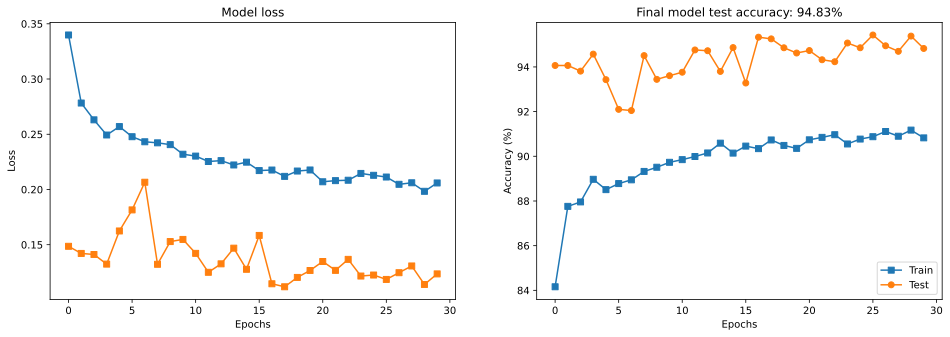

In [31]:
plot_results(mobilenet_model_wf1_trainLoss,mobilenet_model_wf1_devLoss,mobilenet_model_wf1_trainAcc,mobilenet_model_wf1_devAcc)

# Train vit model to improve performance

In [ ]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True, # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)

pytorch_model.bin:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    f"{model_name}-finetuned-eurosat",
    remove_unused_columns=False,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=32,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

In [ ]:
from datasets import load_metric

metric = load_metric("accuracy")

<ipython-input-29-350fcae91df9>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [ ]:
import numpy as np

# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [ ]:
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example[0] for example in examples])
    labels = torch.tensor([example[1] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

In [ ]:
train_results = trainer.train()
# rest is optional but nice to have
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Epoch,Training Loss,Validation Loss,Accuracy
0,0.087400,0.050778,0.994000
1,0.059700,0.026052,0.994800
2,0.061900,0.022971,0.994400
4,0.047600,0.017345,0.995467
5,0.041700,0.015053,0.996267
6,0.030500,0.013123,0.996533
8,0.037200,0.010753,0.996800
9,0.031200,0.010356,0.996667


***** train metrics *****
  epoch                    =          9.95
  total_flos               = 12560762316GF
  train_loss               =        0.0749
  train_runtime            =    2:08:46.30
  train_samples_per_second =         22.65
  train_steps_per_second   =         0.176


In [ ]:
metrics = trainer.evaluate()
# some nice to haves:
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =       9.95
  eval_accuracy           =     0.9968
  eval_loss               =     0.0116
  eval_runtime            = 0:01:58.84
  eval_samples_per_second =     63.109
  eval_steps_per_second   =      1.977
